In [1]:
!nvidia-smi

Sun Jun  4 00:29:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:B1:00.0 Off |                  N/A |
| 22%   24C    P8     5W / 250W |  11007MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:B2:00.0 Off |                  N/A |
| 22%   

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms
import timm

2023-06-08 11:15:24.168519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 11:15:28.756720: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/scratch/shkulkar/python/lib:/usr/local/cuda-11.3/tensorRT-8.0/lib64:/usr/local/cuda-11.3/cudnn-8.2/lib64:/usr/local/cuda-11.3/nccl-2.9/lib64
2023-06-08 11:15:28.757018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object fil

In [5]:

from statistics import mode, mean


class SaveValues():
    def __init__(self, m):
        # register a hook to save values of activations and gradients
        self.activations = None
        self.gradients = None
        self.forward_hook = m.register_forward_hook(self.hook_fn_act)
        self.backward_hook = m.register_backward_hook(self.hook_fn_grad)

    def hook_fn_act(self, module, input, output):
        self.activations = output

    def hook_fn_grad(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove(self):
        self.forward_hook.remove()
        self.backward_hook.remove()


class CAM(object):
    """ Class Activation Mapping """

    def __init__(self, model, target_layer):
        """
        Args:
            model: a base model to get CAM which have global pooling and fully connected layer.
            target_layer: conv_layer before Global Average Pooling
        """

        self.model = model
        self.target_layer = target_layer

        # save values of activations and gradients in target_layer
        self.values = SaveValues(self.target_layer)

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
        Return:
            heatmap: class activation mappings of the predicted class
        """

        # object classification
        score = self.model(x)

        prob = F.softmax(score, dim=1)

        if idx is None:
            prob, idx = torch.max(prob, dim=1)
            idx = idx.item()
            prob = prob.item()
            print("predicted class ids {}\t probability {}".format(idx, prob))

        # cam can be calculated from the weights of linear layer and activations
        weight_fc = list(
            self.model._modules.get('fc').parameters())[0].to('cpu').data

        cam = self.getCAM(self.values, weight_fc, idx)

        return cam, idx

    def __call__(self, x):
        return self.forward(x)

    def getCAM(self, values, weight_fc, idx):
        '''
        values: the activations and gradients of target_layer
            activations: feature map before GAP.  shape => (1, C, H, W)
        weight_fc: the weight of fully connected layer.  shape => (num_classes, C)
        idx: predicted class id
        cam: class activation map.  shape => (1, num_classes, H, W)
        '''

        cam = F.conv2d(values.activations, weight=weight_fc[:, :, None, None])
        _, _, h, w = cam.shape

        # class activation mapping only for the predicted class
        # cam is normalized with min-max.
        cam = cam[:, idx, :, :]
        cam -= torch.min(cam)
        cam /= torch.max(cam)
        cam = cam.view(1, 1, h, w)

        return cam.data


class GradCAM(CAM):
    """ Grad CAM """

    def __init__(self, model, target_layer):
        super().__init__(model, target_layer)

        """
        Args:
            model: a base model to get CAM, which need not have global pooling and fully connected layer.
            target_layer: conv_layer you want to visualize
        """

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
            idx: the index of the target class
        Return:
            heatmap: class activation mappings of the predicted class
        """

        # anomaly detection
        score = self.model(x)

        prob = F.softmax(score, dim=1)

        if idx is None:
            prob, idx = torch.max(prob, dim=1)
            idx = idx.item()
            prob = prob.item()
            print("predicted class ids {}\t probability {}".format(idx, prob))

        # caluculate cam of the predicted class
        cam = self.getGradCAM(self.values, score, idx)

        return cam, idx

    def __call__(self, x):
        return self.forward(x)

    def getGradCAM(self, values, score, idx):
        '''
        values: the activations and gradients of target_layer
            activations: feature map before GAP.  shape => (1, C, H, W)
        score: the output of the model before softmax
        idx: predicted class id
        cam: class activation map.  shape=> (1, 1, H, W)
        '''

        self.model.zero_grad()

        score[0, idx].backward(retain_graph=True)

        activations = values.activations
        gradients = values.gradients
        n, c, _, _ = gradients.shape
        alpha = gradients.view(n, c, -1).mean(2)
        alpha = alpha.view(n, c, 1, 1)

        # shape => (1, 1, H', W')
        cam = (alpha * activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam -= torch.min(cam)
        cam /= torch.max(cam)

        return cam.data


class GradCAMpp(CAM):
    """ Grad CAM plus plus """

    def __init__(self, model, target_layer):
        super().__init__(model, target_layer)
        """
        Args:
            model: a base model
            target_layer: conv_layer you want to visualize
        """

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
            idx: the index of the target class
        Return:
            heatmap: class activation mappings of predicted classes
        """

        # object classification
        score = self.model(x)

        prob = F.softmax(score, dim=1)

        if idx is None:
            prob, idx = torch.max(prob, dim=1)
            idx = idx.item()
            prob = prob.item()
            print("predicted class ids {}\t probability {}".format(idx, prob))

        # caluculate cam of the predicted class
        cam = self.getGradCAMpp(self.values, score, idx)

        return cam, idx

    def __call__(self, x):
        return self.forward(x)

    def getGradCAMpp(self, values, score, idx):
        '''
        values: the activations and gradients of target_layer
            activations: feature map before GAP.  shape => (1, C, H, W)
        score: the output of the model before softmax. shape => (1, n_classes)
        idx: predicted class id
        cam: class activation map.  shape=> (1, 1, H, W)
        '''

        self.model.zero_grad()

        score[0, idx].backward(retain_graph=True)

        activations = values.activations
        gradients = values.gradients
        n, c, _, _ = gradients.shape

        # calculate alpha
        numerator = gradients.pow(2)
        denominator = 2 * gradients.pow(2)
        ag = activations * gradients.pow(3)
        denominator += ag.view(n, c, -1).sum(-1, keepdim=True).view(n, c, 1, 1)
        denominator = torch.where(
            denominator != 0.0, denominator, torch.ones_like(denominator))
        alpha = numerator / (denominator + 1e-7)

        relu_grad = F.relu(score[0, idx].exp() * gradients)
        weights = (alpha * relu_grad).view(n, c, -1).sum(-1).view(n, c, 1, 1)

        # shape => (1, 1, H', W')
        cam = (weights * activations).sum(1, keepdim=True)
        cam = F.relu(cam)
        cam -= torch.min(cam)
        cam /= torch.max(cam)

        return cam.data


class SmoothGradCAMpp(CAM):
    """ Smooth Grad CAM plus plus """

    def __init__(self, model, target_layer, n_samples=25, stdev_spread=0.15):
        super().__init__(model, target_layer)
        """
        Args:
            model: a base model
            target_layer: conv_layer you want to visualize
            n_sample: the number of samples
            stdev_spread: standard deviationß
        """

        self.n_samples = n_samples
        self.stdev_spread = stdev_spread

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
            idx: the index of the target class
        Return:
            heatmap: class activation mappings of predicted classes
        """

        stdev = self.stdev_spread / (x.max() - x.min())
        std_tensor = torch.ones_like(x) * stdev

        indices = []
        probs = []

        for i in range(self.n_samples):
            self.model.zero_grad()

            x_with_noise = torch.normal(mean=x, std=std_tensor)
            x_with_noise.requires_grad_()

            score = self.model(x_with_noise)

            prob = F.softmax(score, dim=1)

            if idx is None:
                prob, idx = torch.max(prob, dim=1)
                idx = idx.item()
                probs.append(prob.item())

            indices.append(idx)

            score[0, idx].backward(retain_graph=True)

            activations = self.values.activations
            gradients = self.values.gradients
            n, c, _, _ = gradients.shape

            # calculate alpha
            numerator = gradients.pow(2)
            denominator = 2 * gradients.pow(2)
            ag = activations * gradients.pow(3)
            denominator += \
                ag.view(n, c, -1).sum(-1, keepdim=True).view(n, c, 1, 1)
            denominator = torch.where(
                denominator != 0.0, denominator, torch.ones_like(denominator))
            alpha = numerator / (denominator + 1e-7)

            relu_grad = F.relu(score[0, idx].exp() * gradients)
            weights = \
                (alpha * relu_grad).view(n, c, -1).sum(-1).view(n, c, 1, 1)

            # shape => (1, 1, H', W')
            cam = (weights * activations).sum(1, keepdim=True)
            cam = F.relu(cam)
            cam -= torch.min(cam)
            cam /= torch.max(cam)

            if i == 0:
                total_cams = cam.clone()
            else:
                total_cams += cam

        total_cams /= self.n_samples
        idx = mode(indices)
        prob = mean(probs)

        print("predicted class ids {}\t probability {}".format(idx, prob))

        return total_cams.data, idx

    def __call__(self, x):
        return self.forward(x)


class ScoreCAM(CAM):
    """ Score CAM """

    def __init__(self, model, target_layer, n_batch=32):
        super().__init__(model, target_layer)
        """
        Args:
            model: a base model
            target_layer: conv_layer you want to visualize
        """
        self.n_batch = n_batch

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
            idx: the index of the target class
        Return:
            heatmap: class activation mappings of predicted classes
        """

        with torch.no_grad():
            _, _, H, W = x.shape
            device = x.device

            self.model.zero_grad()
            score = self.model(x)
            prob = F.softmax(score, dim=1)

            if idx is None:
                p, idx = torch.max(prob, dim=1)
                idx = idx.item()
                # print("predicted class ids {}\t probability {}".format(idx, p))

            # # calculate the derivate of probabilities, not that of scores
            # prob[0, idx].backward(retain_graph=True)

            self.activations = self.values.activations.to('cpu').clone()
            # put activation maps through relu activation
            # because the values are not normalized with eq.(1) without relu.
            self.activations = F.relu(self.activations)
            self.activations = F.interpolate(
                self.activations, (H, W), mode='bilinear')
            _, C, _, _ = self.activations.shape

            # normalization
            act_min, _ = self.activations.view(1, C, -1).min(dim=2)
            act_min = act_min.view(1, C, 1, 1)
            act_max, _ = self.activations.view(1, C, -1).max(dim=2)
            act_max = act_max.view(1, C, 1, 1)
            denominator = torch.where(
                (act_max - act_min) != 0., act_max - act_min, torch.tensor(1.)
            )

            self.activations = self.activations / denominator

            # generate masked images and calculate class probabilities
            probs = []
            for i in range(0, C, self.n_batch):
                mask = self.activations[:, i:i+self.n_batch].transpose(0, 1)
                mask = mask.to(device)
                masked_x = x * mask
                score = self.model(masked_x)
                probs.append(F.softmax(score, dim=1)[:, idx].to('cpu').data)

            probs = torch.stack(probs)
            weights = probs.view(1, C, 1, 1)

            # shape = > (1, 1, H, W)
            cam = (weights * self.activations).sum(1, keepdim=True)
            cam = F.relu(cam)
            cam -= torch.min(cam)
            cam /= torch.max(cam)

        return cam.data, idx

    def __call__(self, x):
        return self.forward(x)

In [6]:
import cv2


def reverse_normalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    x[:, 0, :, :] = x[:, 0, :, :] * std[0] + mean[0]
    x[:, 1, :, :] = x[:, 1, :, :] * std[1] + mean[1]
    x[:, 2, :, :] = x[:, 2, :, :] * std[2] + mean[2]
    return x


def visualize(img, cam):
    """
    Synthesize an image with CAM to make a result image.
    Args:
        img: (Tensor) shape => (1, 3, H, W)
        cam: (Tensor) shape => (1, 1, H', W')
    Return:
        synthesized image (Tensor): shape =>(1, 3, H, W)
    """

    _, _, H, W = img.shape
    cam = F.interpolate(cam, size=(H, W), mode='bilinear', align_corners=False)
    cam = 255 * cam.squeeze()
    heatmap = cv2.applyColorMap(np.uint8(cam), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap.transpose(2, 0, 1))
    heatmap = heatmap.float() / 255
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])

    result = heatmap + img.cpu()
    result = result.div(result.max())

    return result

In [7]:
from imagenet_labels import label2idx, idx2label

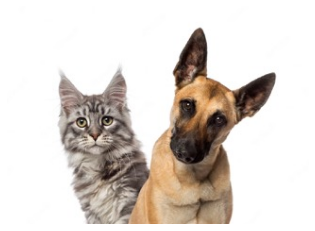

In [8]:

input = Image.open('cat_dog.jpeg')
plt.imshow(input)
plt.axis('off')  # Remove axis labels
plt.show()

In [9]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [10]:
# convert image to tensor
tensor = preprocess(input)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)
tensor.shape

torch.Size([1, 3, 231, 320])

In [11]:
import torchvision.models
# from torchvision.models.resnet import model_urls
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
! export TMPDIR='/var/tmp'
model = torchvision.models.resnet50(pretrained = True)

# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/shkulkar/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


URLError: <urlopen error [Errno 99] Cannot assign requested address>

In [12]:
target_layer = model.layer4[1].conv2
wrapped_model = ScoreCAM(model, target_layer)
cam, idx = wrapped_model(tensor)

NameError: name 'model' is not defined

In [ ]:
print(idx2label[idx])
plt.imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')
plt.show()

In [ ]:
img = reverse_normalize(tensor)
heatmap = visualize(img, cam)


In [ ]:
# Convert heatmap to numpy array
hm = heatmap.squeeze().numpy().transpose(1, 2, 0)

# Normalize the heatmap values to [0, 1]
# hm_normalized = (hm - np.min(hm)) / (np.max(hm) - np.min(hm))
plt.imshow(input)
plt.imshow(hm, cmap='hot', alpha=0.94)
plt.colorbar()
plt.show()

In [3]:
import torch 
from torch.nn import Module,Sequential,Softmax
import torchvision 
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt 
from captum.attr import LayerGradCam,LayerAttribution

from saliency_maps_metrics.single_step_metrics import IIC_AD, ADD 
from saliency_maps_metrics.multi_step_metrics import Deletion, Insertion

In [4]:
val_batch_size = 10

cropped_img_size = 448
img_size=int(cropped_img_size / 0.875)

transf = [transforms.Resize(img_size),transforms.CenterCrop(cropped_img_size)]
transf.extend([transforms.ToTensor()])
transf.extend([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transf = transforms.Compose(transf)

test_dataset = ImageFolder("./data/CUB_200_2011_test/",transform=transf)
testLoader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=val_batch_size,num_workers=4,pin_memory=True,shuffle=True)

batch = test_dataset.__getitem__(0)
plt.figure()
plt.imshow(batch[0].permute(1,2,0).numpy())
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './data/CUB_200_2011_test/'